# Life expectancy - regression
The task is to predict life expectancy for various countries in different years. Training data is in data.csv and data to evaluate is in evaluation.csv. We will use Ridge Regression and ensemble methods - Random Forest (custom implementation) and AdaBoost.

# Features
* Year
* Status - developed or developing country
* Life expectancy - in years, **the target variable**
* Adult Mortality - mortality between the ages of 15 and 60 (per 1000 people)
* infant deaths - per 1000 people
* Alcohol - for people age 15+, in liters
* percentage expenditure - health expenditure in percentages of GDP per capita (%)
* Hepatitis B - coverage of vaccination for children age 1 (%)
* Measles - reported cases per 1000 people
* BMI - average
* under-five deaths - per 1000 people
* Polio - coverage of vaccination for children age 1 (%)
* Total expenditure - government expenditure on healthcare as a percentage of total government expenditure (%)
* Diphtheria - coverage of vaccination for children age 1 (%)
* HIV/AIDS - number of deaths per 1000 children (0-4 years) from HIV/AIDS
* GDP - in USD
* Population
* thinness 1-19 years - ratio of children (10-19 years) with BMI less than 2 standard deviations below the median (%)
* thinness 5-9 years - ratio of children (5-9 years) with BMI less than 2 standard deviations below the median (%)
* Income composition of resources - Human Development Index in terms of income composotion of resources (index between 0 and 1)
* Schooling - years of compulsory education

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid

Custom implementation of Random Forest for regression (using DecisionTreeRegressor from scikit).

* max_depth - the maximum depth of the trees
* max_features - the number of features used to find the best split
* max_samples - the number of samples to train each base estimator
* n_estimators - the number of trees

In [2]:
class CustomRandomForest:
    def __init__(self, n_estimators, max_samples, max_depth, max_features, **kwargs):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.max_features  = max_features
        self.rest_param = kwargs
        self.submodels = []
        
    def fit(self, X, y):
        rows = X.shape[0]
        
        for i in range(self.n_estimators):
            index_list = np.random.choice(rows, self.max_samples, replace=True)
            x_sub = X.iloc[index_list]
            y_sub = y.iloc[index_list]
            
            submodel = DecisionTreeRegressor(max_depth=self.max_depth, max_features=self.max_features, **self.rest_param)
            submodel.fit(x_sub, y_sub)
            self.submodels.append(submodel)
        
    def predict(self, X):
        ypredicted = np.zeros((X.shape[0],))
        
        for submodel in self.submodels:
            ypredicted += submodel.predict(X)
    
        return (ypredicted / self.n_estimators)


## Load data and data preprocessing

Training dataset will be divided into training (60%), validation (20%) and testing (20%) set. We will transform the dataset into a suitable form. Convert necessary columns into category dtype, fill missing values (-1 for categorical features and mean for continuous values)...

In [3]:
df = pd.read_csv('data.csv')

Xdata = df.copy()
Ydata = df['Life expectancy']

rd_seed = 10 # Fixed Seed
train, test, trainRes, testRes = train_test_split(Xdata, Ydata, test_size=0.4, random_state=rd_seed)
val, test, valRes, testRes = train_test_split(test, testRes, test_size=0.5, random_state=rd_seed)

In [4]:
df.head(3)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9


In [5]:
#Convert columns with object dtype into category dtypes and giving them a numeric value
#Missing values are by default given a value of -1
def convert_to_cat (df):
    string_cols = df.select_dtypes(['object']).columns
    df[string_cols] = df[string_cols].astype('category').apply(lambda x: x.cat.codes)
    
    return df

#Fill in missing continuous values. We fill with the mean/average from training set.
def fill_mean (df, train):
    string_cols = df.columns
    
    for x in string_cols:
        if df[x].isnull().sum() > 0:
            df[x].fillna(train[x].mean(), inplace=True)
    
    return df

#Transform the dataframe into workable state (with functions mentioned above).
def transform_df(df, train):
    df = convert_to_cat(df)
    df = fill_mean(df, train)
    
    return df

#Drop predetermined columns from the dataset.
def drop_col(df):
    df.drop(['Life expectancy', 'Country', 'Population'], axis=1, inplace=True)
    return df

NOTE: For categorical feature 'Status', we won't use one-hot encoding since it's binary anyways.

There is quite a lot of missing values in 'Population', 'Hepatitis B' and 'GDP'. However, it is not missing significant enough portion to drop these features (in my opinion).

In [6]:
print(train.shape[0])
train.isnull().sum()

1630


Country                              0
Year                                 0
Status                               0
Life expectancy                      0
Adult Mortality                      0
infant deaths                        0
Alcohol                             90
percentage expenditure               0
Hepatitis B                        330
Measles                              0
BMI                                 17
under-five deaths                    0
Polio                               13
Total expenditure                  114
Diphtheria                          13
HIV/AIDS                             0
GDP                                256
Population                         368
thinness  1-19 years                17
thinness 5-9 years                  17
Income composition of resources     93
Schooling                           93
dtype: int64

In [7]:
train = transform_df(train, train)
val = transform_df(val, train)
test = transform_df(test, train)

In [8]:
train.head(3)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2393,161,2000,1,72.6,125.0,0,2.86,0.000000,80.688462,36,...,96.0,8.52,95.0,0.1,7682.900120,1.030233e+07,2.8,2.8,0.000,11.7
2533,171,2014,1,76.9,77.0,1,1.91,3862.682710,99.000000,344,...,99.0,3.64,99.0,0.1,44449.743500,1.030233e+07,5.2,5.0,0.832,13.3
990,67,2007,1,56.4,36.0,31,0.19,1.399627,57.000000,3,...,46.0,3.80,63.0,2.4,49.456775,1.967270e+05,8.9,8.8,0.364,7.6


In correlation matrix we see that the 'Life expectancy' has practically no correlation with 'Country' and 'Population'. For the sake of simplicity, we will thus drop these two features. Otherwise, we would transform 'Country' values into dummy variables. Better would be to compare RMSE with and without these two features.

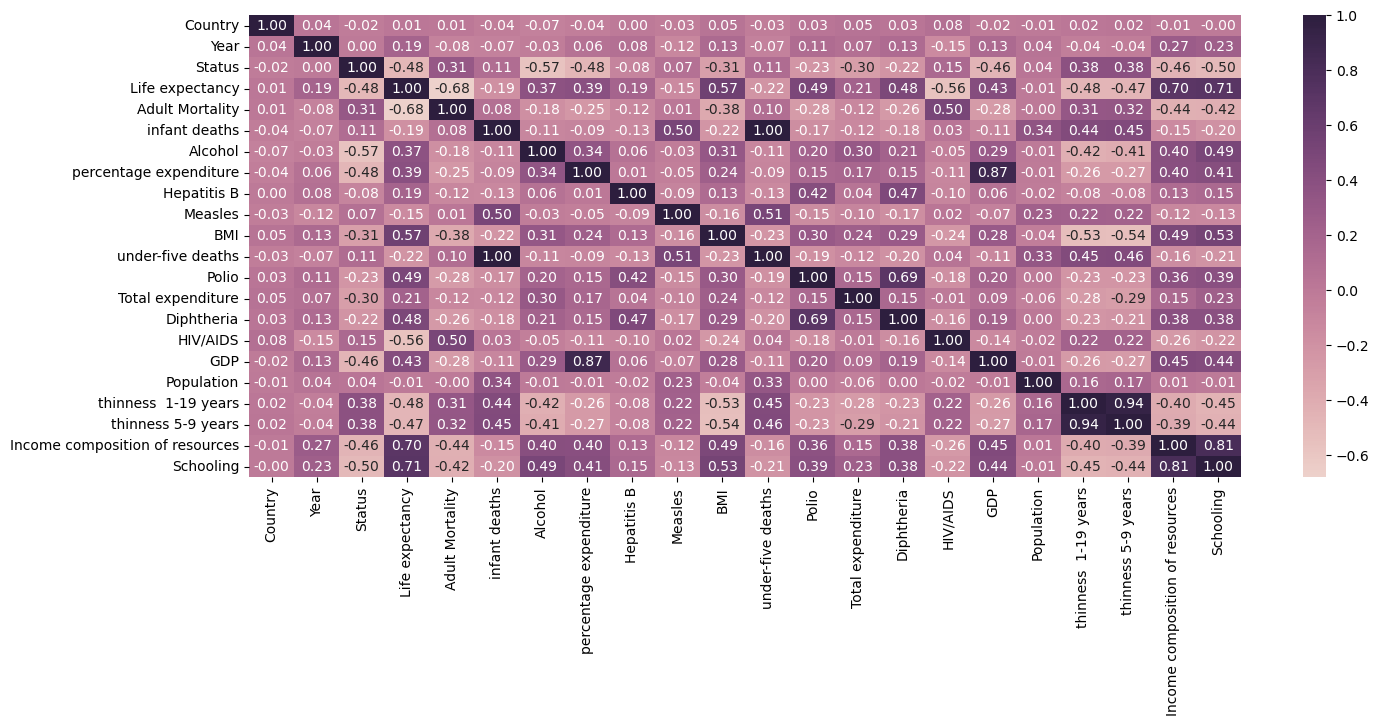

In [9]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.heatmap(train.corr(), cmap=sns.cubehelix_palette(as_cmap=True), annot=True, fmt='.2f', ax=ax)

plt.show()

In [10]:
train = drop_col(train)
val = drop_col(val)
test = drop_col(test)

## Random Forest

Apply Random Forest on data, we will tune these following hyperparameters: n_estimators, max_depth, max_features and max_samples.

Random Forest has pretty high accuracy in regression tasks and is less prone to overfitting. However, it is quite robust and fitting takes quite a bit of time.

Best model is saved to a file so we don't have to wait every time when running the notebook.

In [11]:
f_name = 'random_forest.pickle'

In [12]:
# param_grid = {
#     'n_estimators': [10, 40, 70, 100, 150, 200, 250],
#     'max_depth': range(1,16), 
#     'max_features': ['log2', 'sqrt'],
#     'max_samples': range(1, train.shape[0] + 1, 100),
# }
# param_comb = ParameterGrid(param_grid)

# best_val_rmse = -1
# final_params = {}

# for x in param_comb:
#     random_forest = CustomRandomForest(n_estimators=x['n_estimators'], max_samples=x['max_samples'], 
#                                        max_depth=x['max_depth'], max_features=x['max_features'])
#     random_forest.fit(train, trainRes)
#     val_rmse = metrics.mean_squared_error(valRes, random_forest.predict(val), squared = False)

#     if (val_rmse < best_val_rmse) or (best_val_rmse < 0):
#         final_params = x
#         best_val_rmse = val_rmse

# forest = CustomRandomForest(n_estimators=final_params['n_estimators'], max_samples=final_params['max_samples'], 
#                             max_depth=final_params['max_depth'], max_features=final_params['max_features'])
# forest.fit(train, trainRes)
# pickle.dump(forest, open(f_name, 'wb'))

We see the best hyperparameters and corresponding RMSE and MAE. Model predicts well (on average +-2 years off).

In [13]:
forest = pickle.load(open(f_name, 'rb'))
print('Random Forest:')
print('n_estimators = {}, max_samples = {}, max_depth = {}, max_features = {}'.format(
    forest.n_estimators, forest.max_samples, forest.max_depth, forest.max_features
))

print('')
print('Training RMSE: {0:.3f}'.format(metrics.mean_squared_error(trainRes, forest.predict(train), squared = False)))
print('Training MAE: {0:.3f}'.format(metrics.mean_absolute_error(trainRes, forest.predict(train))))
print('')
print('Validation RMSE: {0:.3f}'.format(metrics.mean_squared_error(valRes, forest.predict(val), squared = False)))
print('Validation MAE: {0:.3f}'.format(metrics.mean_absolute_error(valRes, forest.predict(val))))

Random Forest:
n_estimators = 70, max_samples = 1501, max_depth = 15, max_features = log2

Training RMSE: 0.892
Training MAE: 0.594

Validation RMSE: 2.030
Validation MAE: 1.315


## Ridge Regression

Apply Ridge Regression on data. We will tune the hyperparameter lambda.

This model might not be the best here since it can be biased towards the majority in an unbalanced dataset. It is resistant to overfitting.

In [14]:
def get_opt_ridge(Xtrain, Xval):
    def ridge_model(alpha):
        ridge = Ridge(alpha=alpha)
        ridge.fit(Xtrain, trainRes)
        return metrics.mean_squared_error(valRes, ridge.predict(Xval), squared=False)

    result = optimize.minimize_scalar(ridge_model, options = {'maxiter': 30}, method = 'bounded', bounds=(0.1, 400))
    print('Optimal alpha: ', round(result.x, 3))

    opt_ridge = Ridge(alpha = result.x)
    opt_ridge.fit(Xtrain, trainRes)
    return opt_ridge

We will first try the dataset without any standardization. The result is not very good, the model is on average off by 4.165 years.

In [15]:
print('Ridge Regression without standardization/normalization:')
opt_ridge = get_opt_ridge(train, val)
print('')
print('Training RMSE: {0:.3f}'.format(metrics.mean_squared_error(trainRes, opt_ridge.predict(train), squared = False)))
print('Training MAE: {0:.3f}'.format(metrics.mean_absolute_error(trainRes, opt_ridge.predict(train))))
print('')
print('Validation RMSE: {0:.3f}'.format(metrics.mean_squared_error(valRes, opt_ridge.predict(val), squared = False)))
print('Validation MAE: {0:.3f}'.format(metrics.mean_absolute_error(valRes, opt_ridge.predict(val))))

Ridge Regression without standardization/normalization:
Optimal alpha:  19.334

Training RMSE: 4.158
Training MAE: 3.083

Validation RMSE: 4.165
Validation MAE: 3.164


### Standardization and normalization

Now we standardize our data. The result didn't improve, alpha is quite high here.

In [16]:
scaler = StandardScaler().fit(train)
train_scaled = scaler.transform(train)
val_scaled = scaler.transform(val)

print('Ridge Regression with standardization:')
opt_ridge = get_opt_ridge(train_scaled, val_scaled)
print('')
print('Training RMSE: {0:.3f}'.format(metrics.mean_squared_error(trainRes, opt_ridge.predict(train_scaled), squared = False)))
print('Training MAE: {0:.3f}'.format(metrics.mean_absolute_error(trainRes, opt_ridge.predict(train_scaled))))
print('')
print('Validation RMSE: {0:.3f}'.format(metrics.mean_squared_error(valRes, opt_ridge.predict(val_scaled), squared = False)))
print('Validation MAE: {0:.3f}'.format(metrics.mean_absolute_error(valRes, opt_ridge.predict(val_scaled))))

Ridge Regression with standardization:
Optimal alpha:  199.471

Training RMSE: 4.283
Training MAE: 3.188

Validation RMSE: 4.244
Validation MAE: 3.208


We will now normalize (MinMax) data. The result also didn't improve, alpha is quite low here.

In [17]:
scaler = MinMaxScaler().fit(train)
train_scaled = scaler.transform(train)
val_scaled = scaler.transform(val)

print('Ridge Regression with MinMax normalization:')
opt_ridge = get_opt_ridge(train_scaled, val_scaled)
print('')
print('Training RMSE: {0:.3f}'.format(metrics.mean_squared_error(trainRes, opt_ridge.predict(train_scaled), squared = False)))
print('Training MAE: {0:.3f}'.format(metrics.mean_absolute_error(trainRes, opt_ridge.predict(train_scaled))))
print('')
print('Validation RMSE: {0:.3f}'.format(metrics.mean_squared_error(valRes, opt_ridge.predict(val_scaled), squared = False)))
print('Validation MAE: {0:.3f}'.format(metrics.mean_absolute_error(valRes, opt_ridge.predict(val_scaled))))

Ridge Regression with MinMax normalization:
Optimal alpha:  0.1

Training RMSE: 4.232
Training MAE: 3.145

Validation RMSE: 4.244
Validation MAE: 3.197


### Feature selection

Lastly we will try improving the model by removing "redundant" features - between two features that have high correlation, we keep one. Uncorrelated features might help. The result is however even worse.

In [18]:
train_t = train.copy()
val_t = val.copy()

train_t = train.copy()
val_t = val.copy()
train_t.drop(['under-five deaths', 'percentage expenditure', 'Schooling', 'thinness 5-9 years'], axis=1, inplace=True)
val_t.drop(['under-five deaths', 'percentage expenditure', 'Schooling', 'thinness 5-9 years'], axis=1, inplace=True)

In [19]:
scaler = StandardScaler().fit(train_t)
train_scaled = scaler.transform(train_t)
val_scaled = scaler.transform(val_t)

print('Ridge Regression with standardization (changed dataset):')
opt_ridge = get_opt_ridge(train_scaled, val_scaled)
print('')
print('Training RMSE: {0:.3f}'.format(metrics.mean_squared_error(trainRes, opt_ridge.predict(train_scaled), squared = False)))
print('Training MAE: {0:.3f}'.format(metrics.mean_absolute_error(trainRes, opt_ridge.predict(train_scaled))))
print('')
print('Validation RMSE: {0:.3f}'.format(metrics.mean_squared_error(valRes, opt_ridge.predict(val_scaled), squared = False)))
print('Validation MAE: {0:.3f}'.format(metrics.mean_absolute_error(valRes, opt_ridge.predict(val_scaled))))

Ridge Regression with standardization (changed dataset):
Optimal alpha:  353.97

Training RMSE: 4.485
Training MAE: 3.352

Validation RMSE: 4.479
Validation MAE: 3.354


In [20]:
scaler = MinMaxScaler().fit(train_t)
train_scaled = scaler.transform(train_t)
val_scaled = scaler.transform(val_t)

print('Ridge Regression with MinMax normalization (changed dataset):')
opt_ridge = get_opt_ridge(train_scaled, val_scaled)
print('')
print('Training RMSE: {0:.3f}'.format(metrics.mean_squared_error(trainRes, opt_ridge.predict(train_scaled), squared = False)))
print('Training MAE: {0:.3f}'.format(metrics.mean_absolute_error(trainRes, opt_ridge.predict(train_scaled))))
print('')
print('Validation RMSE: {0:.3f}'.format(metrics.mean_squared_error(valRes, opt_ridge.predict(val_scaled), squared = False)))
print('Validation MAE: {0:.3f}'.format(metrics.mean_absolute_error(valRes, opt_ridge.predict(val_scaled))))

Ridge Regression with MinMax normalization (changed dataset):
Optimal alpha:  2.516

Training RMSE: 4.443
Training MAE: 3.292

Validation RMSE: 4.520
Validation MAE: 3.340


Neither standardization nor normalization helped, maybe the default data has a similar scale to the changed ones already. Feature selection didn't work either.

## AdaBoost

Last model will be AdaBoost. Hyperparameters to tune:

* max_depth - the maximum depth of the trees
* n_estimators - number of trees

AdaBoost is quite good in regression tasks. It is a bit robust and fitting takes quite a bit of time, plus we have to be careful with hyperparameters.

In [21]:
#Transform the dataset for AdaBoost
train_ada = np.array(train, "float64")
val_ada = np.array(val, "float64")
trainRes_ada = np.array(trainRes, "float64")
valRes_ada = np.array(valRes, "float64")

In [22]:
# param_grid = {
#     'n_estimators': range(40, 300, 20),
#     'max_depth': range(1,16)
# }
# param_comb = ParameterGrid(param_grid)

# final_params = {}
# best_val_rmse = -1

# for x in param_comb:
    # ada_tree = DecisionTreeRegressor(max_depth=x['max_depth'])
    # ada = AdaBoostRegressor(estimator=ada_tree, n_estimators=x['n_estimators'], random_state=42).fit(train_ada, trainRes_ada)
    # val_rmse = metrics.mean_squared_error(valRes_ada, ada.predict(val_ada), squared=False)
    
    # if (val_rmse < best_val_rmse) or (best_val_rmse < 0):
    #     best_val_rmse = val_rmse
    #     final_params = x

# ada_tree = DecisionTreeRegressor(max_depth=final_params['max_depth'])
# ada = AdaBoostRegressor(estimator=ada_tree, n_estimators=final_params['n_estimators'], random_state=42)
# ada.fit(train_ada, trainRes_ada)
# # pickle.dump(ada, open('adaboost.pickle', 'wb'))

AdaBoost has very good results. Prediction is on average +-1.8 years off. The depth is however quite high, which isn't very ideal for AdaBoost => overfitting. Increasing n_estimators helps a bit but it isn't a perfect solution.

In [23]:
ada = pickle.load(open('adaboost.pickle', 'rb'))
print('AdaBoost:')
print('n_estimators = {}, max_depth = {}'.format(ada.get_params()['n_estimators'], ada.get_params()['estimator__max_depth']))
print('')
print('Training RMSE: {0:.3f}'.format(metrics.mean_squared_error(trainRes, ada.predict(train_ada), squared = False)))
print('Training MAE: {0:.3f}'.format(metrics.mean_absolute_error(trainRes, ada.predict(train_ada))))
print('')
print('Validation RMSE: {0:.3f}'.format(metrics.mean_squared_error(valRes, ada.predict(val_ada), squared = False)))
print('Validation MAE: {0:.3f}'.format(metrics.mean_absolute_error(valRes, ada.predict(val_ada))))

AdaBoost:
n_estimators = 240, max_depth = 14

Training RMSE: 0.148
Training MAE: 0.062

Validation RMSE: 1.895
Validation MAE: 1.060


## Final model

Validation RMSE and MAE is the best for AdaBoost so it is our final model. The expected error (RMSE) on new data is 1.764 (on average off by +-1.764 years).

In [24]:
test_ada = np.array(test, "float64")
testRes_ada = np.array(testRes, "float64")

print('Final model: AdaBoost')
print('Test RMSE: {0:.3f}'.format(metrics.mean_squared_error(testRes_ada, ada.predict(test_ada), squared = False)))
print('Test MAE: {0:.3f}'.format(metrics.mean_absolute_error(testRes_ada, ada.predict(test_ada))))

Final model: AdaBoost
Test RMSE: 1.764
Test MAE: 1.020


## Final evaluation

Now we let the model predict on data from evaluation.csv and then save it to results.csv.

In [25]:
tmpEvaluation = pd.read_csv('evaluation.csv')
tmpEvaluation.drop(['Population'], axis=1, inplace=True)

evaluation = tmpEvaluation.copy()
evaluation.drop(['Country'], axis=1, inplace=True)
evaluation = transform_df(evaluation, train)

eva_ada = np.array(evaluation, "float64")

tmp = ada.predict(eva_ada)

f = open('results.csv', 'w')
f.write('Country,Year,Life expectancy\n')
for i in range(len(tmp)):
    l = str(tmpEvaluation['Country'].iloc[i]) + ',' + str(tmpEvaluation['Year'].iloc[i]) + ',' + str(tmp[i]) + '\n'
    f.write(l)

f.close()